# Carga de datos y preprocesamiento

In [1]:
import pandas as pd
import numpy as np


In [ ]:
########################################################################################    BBDD CHINA

X_train = pd.read_pickle("./Datasets/China/X_train_China.pkl")
X_train_features = pd.read_pickle("./Datasets/China/X_train_features_China.pkl")
X_val = pd.read_pickle("./Datasets/China/X_val_China.pkl")
X_val_features = pd.read_pickle("./Datasets/China/X_val_features_China.pkl")
X_test = pd.read_pickle("./Datasets/China/X_test_China.pkl")
X_test_features = pd.read_pickle("./Datasets/China/X_test_features_China.pkl")

y_train = pd.read_pickle("./Datasets/China/y_train_China.pkl")
y_val = pd.read_pickle("./Datasets/China/y_val_China.pkl")
y_test = pd.read_pickle("./Datasets/China/y_test_China.pkl")

fs = 1000

In [11]:
########################################################################################    BBDD COLOMBIA
X_train = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/X_train.pkl"))
X_train_features = pd.read_pickle("./Datasets/Colombia/X_train_features.pkl")
X_val = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/X_val.pkl"))
X_val_features = pd.read_pickle("./Datasets/Colombia/X_val_features.pkl")
X_test = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/X_test.pkl"))
X_test_features = pd.read_pickle("./Datasets/Colombia/X_test_features.pkl")

y_train = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/y_train.pkl"))
y_val = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/y_val.pkl"))
y_test = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/y_test.pkl"))

fs = 100

In [3]:
def moving_average(signal, window_size=50):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

In [4]:
############################################################################################# Suavizado solo para BBDD China
# Convertir cada fila del DataFrame en un arreglo de NumPy y aplicar el suavizado
X_train = np.array([moving_average(ppg_signal.values) for _, ppg_signal in X_train.iterrows()]) #Comentar si X_train_China_Augmented ya que está filtrado en el proceso de Data Augmentation
X_val = np.array([moving_average(ppg_signal.values) for _, ppg_signal in X_val.iterrows()])
X_test = np.array([moving_average(ppg_signal.values) for _, ppg_signal in X_test.iterrows()])

In [12]:
# Normalización Min-Max
def normalize_min_max(signals):
    # Calcular mínimos y máximos por fila
    min_vals = np.min(signals, axis=1, keepdims=True)
    max_vals = np.max(signals, axis=1, keepdims=True)
    # Normalizar cada fila
    return (signals - min_vals) / (max_vals - min_vals)

    
X_train = normalize_min_max(X_train.values)
X_val = normalize_min_max(X_val.values)
X_test = normalize_min_max(X_test.values)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Ajustar el escalador en el conjunto de entrenamiento y transformar
X_train_features = scaler.fit_transform(X_train_features)

# Usar el escalador ya ajustado para transformar los subconjuntos de validación y prueba
X_val_features = scaler.transform(X_val_features)
X_test_features = scaler.transform(X_test_features)


In [14]:
import matplotlib.pyplot as plt

def visualize_example(X, Y, metadata, example_idx):
    """
    Visualiza una ventana de señal PPG con su etiqueta y metadatos asociados.
    
    Parámetros:
        X: np.array de señales segmentadas (num_windows, window_size).
        Y: np.array de etiquetas (num_windows,).
        metadata: np.array de metadatos (num_windows, num_features).
        example_idx: Índice del ejemplo a visualizar.
    """
    # Extraer datos del ejemplo
    signal = X[example_idx]
    label = "Normal" if Y[example_idx] else "Anormal"
    metadata_example = metadata[example_idx]

    # Crear la figura
    plt.figure(figsize=(12, 6))
    
    # Graficar la señal
    plt.plot(signal, label=f"PPG Signal (Window {example_idx})", color='blue')
    plt.title(f"Señal PPG - Etiqueta: {label}")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud Normalizada")
    plt.grid()
    plt.legend()

    # Mostrar los metadatos
    plt.text(
        0.05, -0.2,
        f"Metadatos normalizados:\nSystolic BP: {metadata_example[0]:.2f}\nDiastolic BP: {metadata_example[1]:.2f}\nHeart Rate: {metadata_example[2]:.2f}",
        transform=plt.gca().transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8)
    )

    plt.tight_layout()
    plt.show()


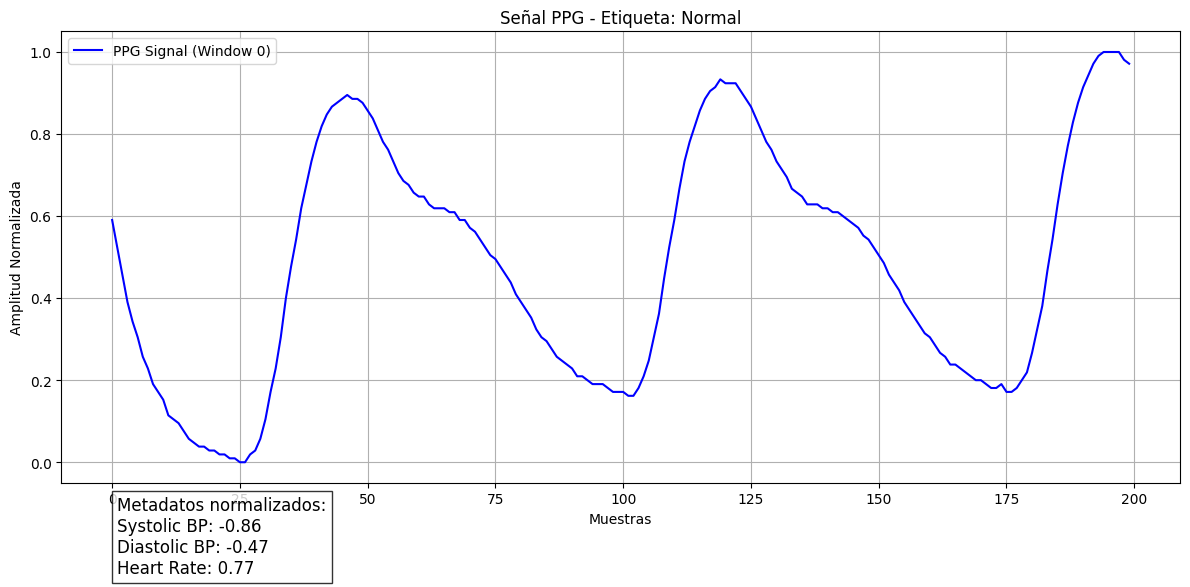

In [15]:
# Visualizar un ejemplo del conjunto de entrenamiento
example_idx = 0  # Cambia el índice para explorar diferentes ejemplos
visualize_example(X_train, y_train.values, X_train_features, example_idx)

In [16]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = y_train.astype(int).values.ravel()
y_val = y_val.astype(int).values.ravel()
y_test = y_test.astype(int).values.ravel()

# Modelo

In [17]:
from keras.callbacks import TensorBoard

import os

# Crear carpeta para guardar los logs de TensorBoard
log_dir = os.path.join("logs", "modelo_cnn_resnet_bilstm_metadatos")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Verificar la carpeta creada
print(f"Logs de TensorBoard se guardarán en: {log_dir}")

Logs de TensorBoard se guardarán en: logs\modelo_cnn_resnet_bilstm_metadatos


## Bloques Residuales con AvgPool

In [18]:
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, Dropout, Add,
    AveragePooling1D, Bidirectional, LSTM, GlobalMaxPooling1D, Dense
)
from tensorflow.keras.models import Model
import tensorflow as tf

def residual_block(x, filters):
    shortcut = Conv1D(filters, kernel_size=1, padding='same')(x)

    x = Conv1D(filters, kernel_size=7, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = Conv1D(filters, kernel_size=7, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    # Cambiamos a AvgPooling
    x = AveragePooling1D(pool_size=2)(x)
    return x

In [19]:
def create_resnet_bilstm_model(input_shape_ppg, input_shape_metadata):
    # Entrada de PPG
    ppg_input = Input(shape=input_shape_ppg, name='PPG_Input')

    # Primera capa convolucional
    x = Conv1D(64, kernel_size=15, padding="same")(ppg_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Bloques ResNet
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    # BiLSTM
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(x)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3))(x)

    # Entrada de metadatos
    metadata_input = Input(shape=input_shape_metadata, name='Metadata_Input')

    # Concatenación de características extraídas
    x = tf.keras.layers.Concatenate()([x, metadata_input])

    # Capas densas
    x = Dense(64, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    x = Dense(32, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    # Capa de salida
    outputs = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[ppg_input, metadata_input], outputs=outputs)
    return model


## Creación del modelo

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-bce)
        focal_loss = alpha * (1 - pt) ** gamma * bce
        return focal_loss
    return loss

# Crear el modelo
# Entrenar con un optimizador avanzado
input_shape_ppg = (X_train.shape[1], X_train.shape[2])  # Ventanas PPG
input_shape_metadata = (X_train_features.shape[1],)  # Metadatos

model = create_resnet_bilstm_model(input_shape_ppg, input_shape_metadata)

optimizer = AdamW(learning_rate=0.0005)
#optimizer=Adam(learning_rate=0.001)
# Compilar
model.compile(optimizer = optimizer,
              loss=focal_loss(),  # Cambiar a Focal Loss si es necesario
              metrics=['accuracy', AUC()])

model.save("./Modelos/modelo_cnn_resnet_bilstm_metadatos/modelo_cnn_resnet_bilstm_metadatos.keras")

# Callbacks
# Ajustar ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=2,  # Reducir más agresivamente
    min_lr=1e-6
)

# Ajustar EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=8,  # Permitir más épocas sin mejora
    restore_best_weights=True
)

checkpoint = ModelCheckpoint("./Modelos/modelo_cnn_resnet_bilstm_metadatos/best_model.keras", save_best_only=True, monitor='val_loss')

# Calcular los pesos de clases
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Convertir a diccionario para Keras
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Verificar los pesos
print("✅ Pesos de clases calculados:")
print(class_weights)

model.summary()

✅ Pesos de clases calculados:
{0: np.float64(0.7894736842105263), 1: np.float64(1.3636363636363635)}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ PPG_Input (InputLayer)        │ (None, 200, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 200, 64)           │           1,024 │ PPG_Input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 200, 64)           │             256 │ conv1d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 200, 64)           │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 200, 64)           │          28,736 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 200, 64)           │             256 │ conv1d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 200, 64)           │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 200, 64)           │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 200, 64)           │          28,736 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 200, 64)           │             256 │ conv1d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 200, 64)           │           4,160 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 200, 64)           │               0 │ batch_normalization_2[0][… │
│                               │                           │                 │ conv1d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 200, 64)           │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling1d             │ (None, 100, 64)           │               0 │ activation_2[0][0]         │
│ (AveragePooling1D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_5 (Conv1D)             │ (None, 100, 64)           │          28,73

 Total params: 992,833 (3.79 MB)

 Trainable params: 990,977 (3.78 MB)

 Non-trainable params: 1,856 (7.25 KB)

## Entrenamiento

In [21]:
# Entrenar el modelo
history = model.fit(
    [X_train, X_train_features], y_train,
    validation_data=([X_val, X_val_features], y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,  # Ponderación de clases
    callbacks=[reduce_lr, early_stopping, checkpoint]
)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 242ms/step - accuracy: 0.6647 - auc: 0.7640 - loss: 1.2615 - val_accuracy: 0.8750 - val_auc: 0.9444 - val_loss: 1.0529 - learning_rate: 5.0000e-04
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.8038 - auc: 0.9092 - loss: 0.9808 - val_accuracy: 0.8750 - val_auc: 0.9590 - val_loss: 0.8204 - learning_rate: 5.0000e-04
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.8346 - auc: 0.9330 - loss: 0.7612 - val_accuracy: 0.8750 - val_auc: 0.9821 - val_loss: 0.6375 - learning_rate: 5.0000e-04
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8775 - auc: 0.9562 - loss: 0.5849 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.4941 - learning_rate: 5.0000e-04
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.8996 - auc: 0.9741 - loss: 0.4466 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.3808 - learning_rate: 5.0000e-04
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accu

# RESULTADOS ENTRENAMIENTO

In [22]:
test_loss, test_accuracy, test_auc = model.evaluate([X_val, X_val_features], y_val)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9065 - auc: 0.6899 - loss: 0.0222     
Test Loss: 0.0189
Test Accuracy: 0.8942
Test AUC: 0.9658


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step


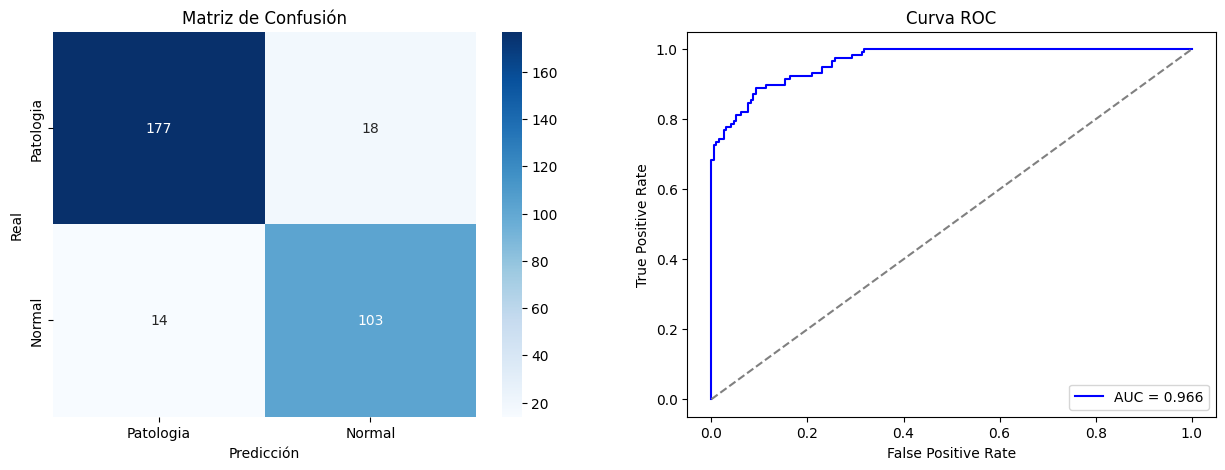


Umbral óptimo: 0.43717461824417114

Reporte de Clasificación:
               precision    recall  f1-score   support

   Patologia       0.93      0.91      0.92       195
      Normal       0.85      0.88      0.87       117

    accuracy                           0.90       312
   macro avg       0.89      0.89      0.89       312
weighted avg       0.90      0.90      0.90       312



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs_val = model.predict([X_val, X_val_features])  # Devuelve las probabilidades para cada clase


# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs_val)
roc_auc = auc(fpr, tpr)
# Calcular la diferencia entre TPR y FPR
optimal_idx = np.argmax(tpr - fpr)  # Índice del umbral óptimo
optimal_threshold = thresholds[optimal_idx]  # Umbral óptimo


threshold = optimal_threshold  # Umbral de decisión
y_pred = (y_pred_probs_val > threshold).astype(int)  # 1 para "Normal", 0 para "Anormal"
#y_pred = (y_pred_probs_test > 0.5).astype(int)  # Convierte a 0 o 1

# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_pred)



# Graficar la matriz de confusión
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Patologia", "Normal"], yticklabels=["Patologia", "Normal"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")


# Graficar la curva ROC
plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Línea de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

print(f"\nUmbral óptimo: {optimal_threshold}\n" )

# Reporte de clasificación
print("Reporte de Clasificación:\n", classification_report(y_val, y_pred, target_names=['Patologia', 'Normal']))


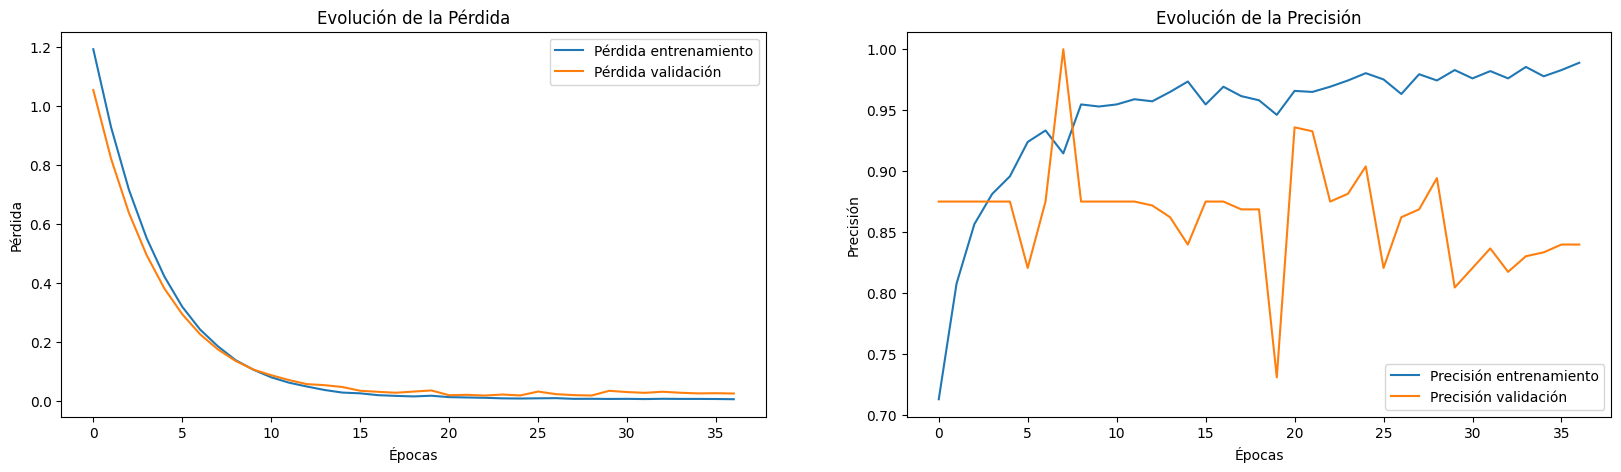

In [24]:
plt.figure(figsize=(20, 5))

# Gráfica de la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title("Evolución de la Pérdida")

# Gráfica de la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title("Evolución de la Precisión")

plt.show()

# RESULTADOS FUERA DE MUESTRA

In [25]:
test_loss, test_accuracy, test_auc = model.evaluate([X_test, X_test_features], y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7312 - auc: 0.9110 - loss: 0.0332         
Test Loss: 0.0160
Test Accuracy: 0.9000
Test AUC: 0.9852


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


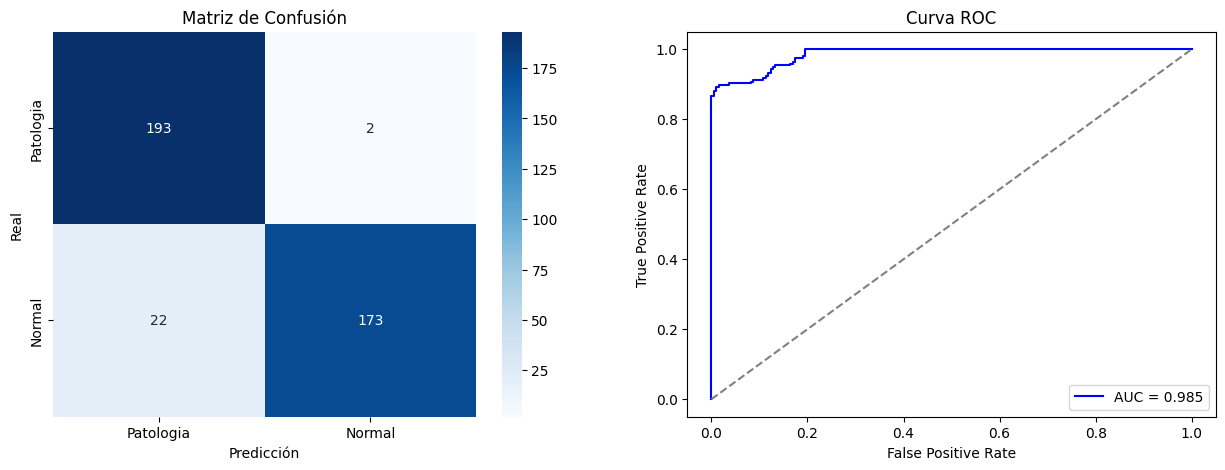


Umbral óptimo: 0.6762039661407471

Reporte de Clasificación:
               precision    recall  f1-score   support

   Patologia       0.90      0.99      0.94       195
      Normal       0.99      0.89      0.94       195

    accuracy                           0.94       390
   macro avg       0.94      0.94      0.94       390
weighted avg       0.94      0.94      0.94       390



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs_test = model.predict([X_test, X_test_features])  # Devuelve las probabilidades para cada clase


# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs_test)
roc_auc = auc(fpr, tpr)
# Calcular la diferencia entre TPR y FPR
optimal_idx = np.argmax(tpr - fpr)  # Índice del umbral óptimo
optimal_threshold = thresholds[optimal_idx]  # Umbral óptimo


threshold = optimal_threshold  # Umbral de decisión
y_pred = (y_pred_probs_test > threshold).astype(int)  # 1 para "Normal", 0 para "Anormal"
#y_pred = (y_pred_probs_test > 0.5).astype(int)  # Convierte a 0 o 1

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)



# Graficar la matriz de confusión
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Patologia", "Normal"], yticklabels=["Patologia", "Normal"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")


# Graficar la curva ROC
plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Línea de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

print(f"\nUmbral óptimo: {optimal_threshold}\n" )

# Reporte de clasificación
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred, target_names=['Patologia', 'Normal']))


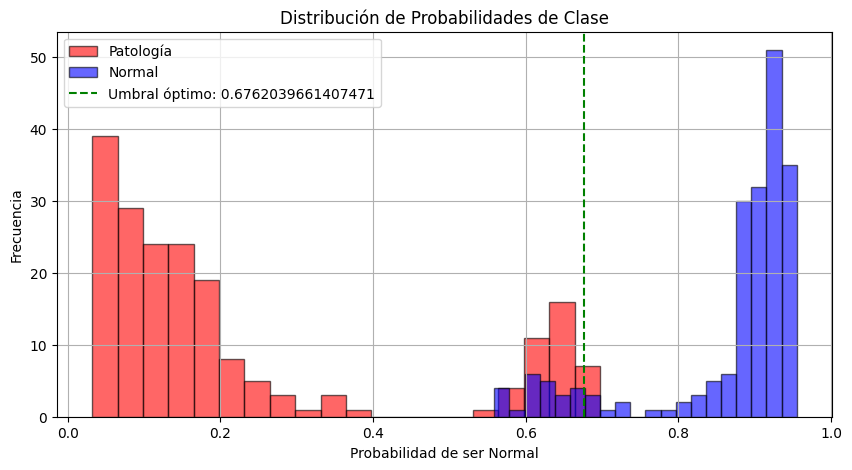

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Separar las probabilidades según la clase
proba_normal = y_pred_probs_test[y_test == 1]  # Probabilidades de la clase "Normal"
proba_patologia = y_pred_probs_test[y_test == 0]  # Probabilidades de la clase "Patologia"

# Crear histogramas
plt.figure(figsize=(10, 5))
plt.hist(proba_patologia, bins=20, alpha=0.6, label="Patología", color='red', edgecolor='black')
plt.hist(proba_normal, bins=20, alpha=0.6, label="Normal", color='blue', edgecolor='black')

# Personalización
plt.axvline(x=optimal_threshold, color='green', linestyle='dashed', label=f"Umbral óptimo: {optimal_threshold}")
plt.xlabel("Probabilidad de ser Normal")
plt.ylabel("Frecuencia")
plt.title("Distribución de Probabilidades de Clase")
plt.legend()
plt.grid(True)
plt.show()



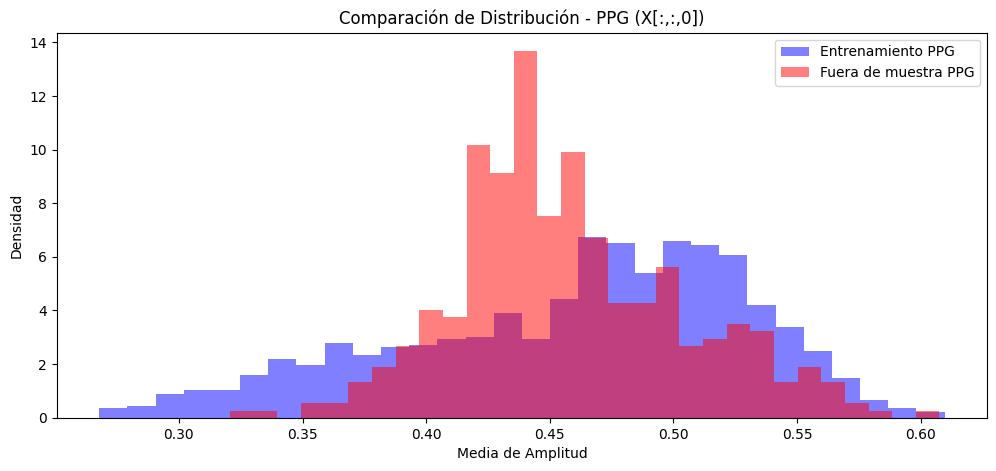

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(np.mean(X_train[:,:,0], axis=1), bins=30, alpha=0.5, label="Entrenamiento PPG", color='blue', density=True)
plt.hist(np.mean(X_test[:,:,0], axis=1), bins=30, alpha=0.5, label="Fuera de muestra PPG", color='red', density=True)
plt.xlabel("Media de Amplitud")
plt.ylabel("Densidad")
plt.legend()
plt.title("Comparación de Distribución - PPG (X[:,:,0])")
plt.show()

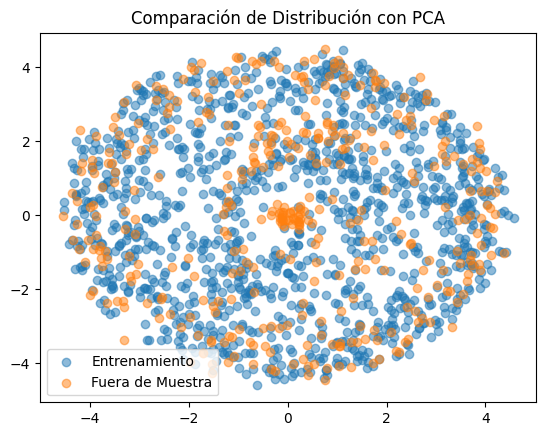

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train[:,:,0])
X_test_pca = pca.transform(X_test[:,:,0])

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label="Entrenamiento", alpha=0.5)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], label="Fuera de Muestra", alpha=0.5)
plt.legend()
plt.title("Comparación de Distribución con PCA")
plt.show()

# Guardar el modelo

In [24]:
from tensorflow.keras.utils import plot_model
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)

plot_model(model, to_file='./Modelos/modelo_cnn_resnet_bilstm_metadatos/model_plot.png', show_shapes=True, show_layer_names=True)

visualkeras.layered_view(
    model, 
    font=font,
    legend=True, 
    spacing=50,  # Más espacio entre capas
    scale_xy=2,  # Escala horizontal/vertical
    scale_z=1    # Reducir la profundidad 3D para que sea más claro
).save('./Modelos/modelo_cnn_resnet_bilstm_metadatos/keras_3D.png')

visualkeras.layered_view(
    model, 
    font=font,
    legend=True, 
    spacing=40, 
    draw_volume=False  # Desactiva la vista en 3D
).save('./Modelos/modelo_cnn_resnet_bilstm_metadatos/keras_2D.png')


C:\Users\Fernando\tfm_env\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
